In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Building a DIY Multimodal Question Answering System with Vertex AI (A Beginner's Guide - Multimodal RAG)

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/qa-ops/building_DIY_multimodal_qa_system_with_mRAG.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Fqa-ops%2Fbuilding_DIY_multimodal_qa_system_with_mRAG.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/qa-ops/building_DIY_multimodal_qa_system_with_mRAG.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/qa-ops/building_DIY_multimodal_qa_system_with_mRAG.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>    
</table>

| | |
|-|-|
|Author(s) | [Lavi Nigam](https://github.com/lavinigam-gcp) |

## Overview


This guide is your hands-on introduction to creating a question answering system that understands both text and images. We'll build this system from the ground up using Google's Vertex AI, giving you a clear understanding of how it works without relying on complex third-party tools.


## Why Build It Yourself?

Large Language Models (LLMs) are powerful, but they can seem like a "black box". By building our own system, we'll break open that box and explore the core concepts. This will give you the knowledge to customize and optimize every aspect of your question answering system, whether you ultimately choose to code everything yourself or use external libraries.


## What We'll Do:

* **Focus on Fundamentals**: We'll start with the essential design pattern of "Retrieval Augmented Generation" (RAG) – a way to find and use relevant information to answer questions.

* **Work with Text and Images**: We'll expand RAG to handle both text and images found in PDF documents. Future guides in this series will explore even more types of data, like videos and audio.

* **Use Vertex AI**: We'll only use Google's Vertex AI Embeddings API and Gemini API, ensuring you have complete control and understanding of the building blocks.


By the end of this guide, you'll have a solid foundation in building multimodal question answering systems, empowering you to create smarter applications that can understand and respond to a wider range of information.


### Gemini

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini 2.0 & Gemini 1.5 models.

### Comparing text-based and multimodal RAG

Multimodal RAG offers several advantages over text-based RAG:

1. **Enhanced knowledge access:** Multimodal RAG can access and process both textual and visual information, providing a richer and more comprehensive knowledge base for the LLM.
2. **Improved reasoning capabilities:** By incorporating visual cues, multimodal RAG can make better informed inferences across different types of data modalities.

This notebook shows you how to implement DIY RAG with Vertex AI Gemini API
 and Vertex AI Embeddings API; [text embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-embeddings), and [multimodal embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/multimodal-embeddings), to build a document search engine.

Through hands-on examples, you will discover how to construct a multimedia-rich metadata repository of your document sources, enabling search, comparison, and reasoning across diverse information streams.

### Objectives

This notebook provides a guide to building a document search engine using multimodal retrieval augmented generation (RAG), step by step:

1. Extract and store metadata of documents containing both text and images, and generate embeddings the documents
2. Search the metadata with text queries to find similar text or images
3. Search the metadata with image queries to find similar images
4. Using a text query as input, search for contextual answers using both text and images

### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK for Python and other dependencies


In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform pymupdf rich

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
                                                                                                                                                                                                                                                                                                                                                          # Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()                                                                                                                                        
app.kernel.do_shutdown(True)                                                                                                                                                                                                                                                                                                                                                                                

{'status': 'ok', 'restart': True}

: 

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information


In [2]:
# Define project information

import sys

PROJECT_ID = "gen-lang-client-0303567819"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# if not running on colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")

Your project ID is: gen-lang-client-0303567819


Your active configuration is: [personal]


In [3]:
import sys

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [4]:
from rich import print as rich_print
from rich.markdown import Markdown as rich_Markdown
from IPython.display import Markdown, display
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)
from vertexai.language_models import TextEmbeddingModel
from vertexai.vision_models import MultiModalEmbeddingModel

### Load the Gemini 2.0 Flash , Gemini 1.5 Flash and Gemini 1.5 Pro Flash


Learn more about each models and their differences: [here](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/send-multimodal-prompts)

Learn about the quotas: [here](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas)

## Overview

**YouTube Video: Introduction to Gemini on Vertex AI**

<a href="https://www.youtube.com/watch?v=YfiLUpNejpE&list=PLIivdWyY5sqJio2yeg1dlfILOUO2FoFRx" target="_blank">
  <img src="https://img.youtube.com/vi/YfiLUpNejpE/maxresdefault.jpg" alt="Introduction to Gemini on Vertex AI" width="500">
</a>

[Gemini 2.0 Flash](https://cloud.google.com/vertex-ai/generative-ai/docs/gemini-v2) is a new multimodal generative ai model from the Gemini family developed by [Google DeepMind](https://deepmind.google/). It is available through the Gemini API in Vertex AI and Vertex AI Studio. The model introduces new features and enhanced core capabilities:

- Multimodal Live API: This new API helps you create real-time vision and audio streaming applications with tool use.
- Speed and performance: Gemini 2.0 Flash is the fastest model in the industry, with a 3x improvement in time to first token (TTFT) over 1.5 Flash.
- Quality: The model maintains quality comparable to larger models like Gemini 1.5 Pro and GPT-4o.
- Improved agentic experiences: Gemini 2.0 delivers improvements to multimodal understanding, coding, complex instruction following, and function calling.
- New Modalities: Gemini 2.0 introduces native image generation and controllable text-to-speech capabilities, enabling image editing, localized artwork creation, and expressive storytelling.
- To support the new model, we're also shipping an all new SDK that supports simple migration between the Gemini Developer API and the Gemini API in Vertex AI.

In [5]:
# Multimodal models: Choose based on your performance/cost needs

multimodal_model_2_0_flash = GenerativeModel(
    "gemini-2.0-flash-001"
) # Gemini latest Gemini 2.0 Flash Model

multimodal_model_15 = GenerativeModel(
    "gemini-1.5-pro-001"
)  # works with text, code, images, video(with or without audio) and audio(mp3) with 1M input context - complex reasoning

# Multimodal models: Choose based on your performance/cost needs
multimodal_model_15_flash = GenerativeModel(
    "gemini-1.5-flash-001"
)  # works with text, code, images, video(with or without audio) and audio(mp3) with 1M input context - faster inference

# Load text embedding model from pre-trained source
text_embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-005")

# Load multimodal embedding model from pre-trained source
multimodal_embedding_model = MultiModalEmbeddingModel.from_pretrained(
    "multimodalembedding@001"
)  # works with image, image with caption(~32 words), video, video with caption(~32 words)

/home/luizeng/Documents/fanshawe_repo/test-image-text-gemini/.venv/lib/python3.13/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
/home/luizeng/Documents/fanshawe_repo/test-image-text-gemini/.venv/lib/python3.13/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
E0000 00:00:1759076507.114519   46051 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
/home/luizeng/Documents/fanshawe_repo/test-image-text-gemini/.venv/lib/python3

#### Get documents and images from GCS

In [11]:
# download documents and images used in this notebook - will take ~30 sec
!gsutil -m -q rsync -r gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2 .
print("Download completed")

Download completed


## Building metadata of documents containing text and images

### The data

The source data that you will use in this notebook are:


* [Google Cloud TPU Scaling blog](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/Google%20Cloud%20TPU%20blog.pdf)
* [Gemini 1.5 Technical Report](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/gemini_v1_5_report_technical.pdf)
* [Google Gemma Technical Paper](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/gemma_technical_paper.pdf)
* [Med-Gemini Technical Paper](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/med_gemini.pdf)



You can also use your data, by first deleting the current files and then placing your files in the `data/` folder.

### Import helper functions to build metadata

Before building the Multimodal Question Answering System with Vertex AI, it's important to have metadata of all the text and images in the document. For references and citations purposes, the metadata should contain essential elements, including page number, file name, image counter, and so on. Hence, as a next step, you will generate embeddings from the metadata, which is required to perform similarity search when querying the data.

In [6]:
from multimodal_qa_with_rag_utils import (
    get_document_metadata,
    set_global_variable,
)

set_global_variable("text_embedding_model", text_embedding_model)
set_global_variable("multimodal_embedding_model", multimodal_embedding_model)

 You can also view the code (`multimodal_qa_with_rag_utils`) [directly](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/utils/multimodal_qa_with_rag_utils.py).

### Extract and store metadata of text and images from a document

You just imported a function called `get_document_metadata()`. This function extracts text and image metadata from a document, and returns two dataframes, namely *text_metadata* and *image_metadata*, as outputs. If you want to find out more about how `get_document_metadata()` function is implemented using Gemini and the embedding models, you can take look at the [source code](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py) directly.

The reason for extraction and storing both text metadata and image metadata is that just by using either of the two alone is not sufficient to come out with a relevent answer. For example, the relevant answers could be in visual form within a document, but text-based RAG won't be able to take into consideration of the visual images. You will also be exploring this example later in this notebook.


At the next step, you will use the function to extract and store metadata of text and images froma document. Please note that the following cell may take a few minutes to complete:

**NOTE: Given that we are loading 4 files with roughly 200 pages and approximately 84 images, the cell below will take approximately 7 minutes to run. We recommend loading pre-computed metadata instead.**

In [7]:
%%time
# Specify the PDF folder with multiple PDF ~7m

print("Removing pre-exsisting images folder, since you are running the logic from scratch")
! rm -rf images/

pdf_folder_path = "map/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
# image_description_prompt = """Explain what is going on in the image.
# If it's a table, extract all elements of the table.
# If it's a graph, explain the findings in the graph.
# Do not include any numbers that are not mentioned in the image.
# """

image_description_prompt = """You are a technical image analysis expert. You will be provided with various types of images extracted from documents like research papers, technical blogs, and more.
Your task is to generate concise, accurate descriptions of the images without adding any information you are not confident about.
Focus on capturing the key details, trends, or relationships depicted in the image.

Important Guidelines:
* Prioritize accuracy:  If you are uncertain about any detail, state "Unknown" or "Not visible" instead of guessing.
* Avoid hallucinations: Do not add information that is not directly supported by the image.
* Be specific: Use precise language to describe shapes, colors, textures, and any interactions depicted.
* Consider context: If the image is a screenshot or contains text, incorporate that information into your description.
"""


# Extract text and image metadata from the PDF document
text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model_2_0_flash,  # we are passing gemini 2.0 Flash Model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
    # add_sleep_after_page = True, # Uncomment this if you are running into API quota issues
    # sleep_time_after_page = 5,
    add_sleep_after_document=True,  # Uncomment this if you are running into API quota issues
    sleep_time_after_document=5,    # Increase the value in seconds, if you are still getting quota issues. It will slow down the processing.
    # generation_config = # see next cell
    # safety_settings =  # see next cell
)

print("\n\n --- Completed processing. ---")


Removing pre-exsisting images folder, since you are running the logic from scratch


 Processing the file: --------------------------------- map/map.pdf 


Processing page: 1


E0000 00:00:1759071556.828705   23808 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759071556.830144   23808 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.



 
 Sleeping for  5  sec before processing the next document to avoid quota issues. You can disable it: "add_sleep_after_document = False"  


 --- Completed processing. ---
CPU times: user 125 ms, sys: 32.7 ms, total: 158 ms
Wall time: 6.97 s


If you would like to pass additional parameters to Gemini while building metadata, here are some options:

In [ ]:
# # Parameters for Gemini API call.
# # reference for parameters: https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/gemini

# generation_config=  GenerationConfig(temperature=0.2, max_output_tokens=2048)

# # Set the safety settings if Gemini is blocking your content or you are facing "ValueError("Content has no parts")" error or "Exception occured" in your data.
# # ref for settings and thresholds: https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/configure-safety-attributes

# safety_settings = {
#                   HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
#                   HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
#                   }

# # You can also pass parameters and safety_setting to "get_gemini_response" function

### Load pre-computed metadata of text and images from source document

**If you are facing constant issues with Quota or want to focus on the outputs, you should load pre-computed metadata.**

In [ ]:
# # [Optional]
# import pickle

# # Load the pickle file
# with open("mrag_metadata.pkl", "rb") as f:
#     data = pickle.load(f)

# # Extract the DataFrames
# text_metadata_df = data["text_metadata"]
# image_metadata_df = data["image_metadata"]

#### Inspect the processed text metadata


The following cell will produce a metadata table which describes the different parts of text metadata, including:

- **text**: the original text from the page
- **text_embedding_page**: the embedding of the original text from the page
- **chunk_text**: the original text divided into smaller chunks
- **chunk_number**: the index of each text chunk
- **text_embedding_chunk**: the embedding of each text chunk

In [8]:
text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,map.pdf,1,I \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,"[-0.00932532362639904, -0.033891454339027405, ...",1,I \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,"[-0.017712244763970375, -0.032180916517972946,..."
1,map.pdf,1,I \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,"[-0.00932532362639904, -0.033891454339027405, ...",2,Housing Registry (F1002)\nResidence Office (R...,"[0.022167837247252464, -0.03107241913676262, 0..."
2,map.pdf,1,I \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,"[-0.00932532362639904, -0.033891454339027405, ...",3,\nHealth & Safety/Facilities (D1021)\nHuman Re...,"[0.00795393344014883, -0.03503992408514023, 0...."
3,map.pdf,1,I \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,"[-0.00932532362639904, -0.033891454339027405, ...",4,dle Building\nat 137 Dundas Street.\nTo Fansha...,"[0.006327552255243063, -0.07151074707508087, 0..."
4,map.pdf,1,I \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,"[-0.00932532362639904, -0.033891454339027405, ...",5,a\nThe Junction\nBookstore\nCareer Services\nC...,"[0.011586909182369709, -0.03213056921958923, 0..."


#### Inspect the processed image metadata

The following cell will produce a metadata table which describes the different parts of image metadata, including:
* **img_desc**: Gemini-generated textual description of the image.
* **mm_embedding_from_text_desc_and_img**: Combined embedding of image and its description, capturing both visual and textual information.
* **mm_embedding_from_img_only**: Image embedding without description, for comparison with description-based analysis.
* **text_embedding_from_image_description**: Separate text embedding of the generated description, enabling textual analysis and comparison.

In [9]:
image_metadata_df.head()

""


### Import the helper functions to implement RAG

You will be importing the following functions which will be used in the remainder of this notebook to implement RAG:

* **get_similar_text_from_query():** Given a text query, finds text from the document which are relevant, using cosine similarity algorithm. It uses text embeddings from the metadata to compute and the results can be filtered by top score, page/chunk number, or embedding size.
* **print_text_to_text_citation():** Prints the source (citation) and details of the retrieved text from the `get_similar_text_from_query()` function.
* **get_similar_image_from_query():** Given an image path or an image, finds images from the document which are relevant. It uses image embeddings from the metadata.
* **print_text_to_image_citation():** Prints the source (citation) and the details of retrieved images from the `get_similar_image_from_query()` function.
* **get_gemini_response():** Interacts with a Gemini model to answer questions based on a combination of text and image inputs.
* **display_images():**  Displays a series of images provided as paths or PIL Image objects.

In [10]:
from multimodal_qa_with_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
    get_answer_from_qa_system,
)

Before implementing a Multimodal Question Answering System with Vertex AI, let's explore what you can achieve with just text or image embeddings. This will set the foundation for implementing a multimodal Retrieval Augmented Generation (RAG) system, which you will do later in this notebook.

You can also use these essential elements together to build applications for multimodal use cases, extracting meaningful information from documents.

## Text Search

Let's start the search with a simple question and see if the simple text search using text embeddings can answer it. The expected answer is to show the value of basic and diluted net income per share of Google for different share types.


In [16]:
query = "What are the buildings in the map, give letters and names of them?"

In [26]:
query = "List the buildings in the map, give letters and names of them? And in the count of them"

In [ ]:
#query = "What are various med-gemini medical benchmarks that shows its performance relative to other models?"

### Search similar text with text query

In [27]:
# Matching user text query with "chunk_embedding" to find relevant chunks.
matching_results_text = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=3,
    chunk_text=True,
)

# Print the matched text citations
print_text_to_text_citation(
    matching_results_text, print_top=True, chunk_text=True
)  # print_top=False to see all text matches

Citation 1: Matched text: 

score:  0.54
file_name:  map.pdf
page_number:  1
chunk_number:  5
chunk_text:  a
The Junction
Bookstore
Career Services
Co-operative
Education
D1063
Saffrons
Restaurant
Olive
Oyle's
Deli
Parking Office
D1018
Security
Control Centre
Print
Shop
B Food
Court
JamesA. Colvin
Atrium
(Cafeteria)
Receiving
After Hours Entrance
H Cafeteria
Siskind Gallery
Falcon House
Residence
Merlin House
Residence
K
R1
R3
Student Centre
SC
Peregrine House
Residence
R2
Gym 1 & 2
Gym 3
J
Student Union Building
SUB
Library
M
F
C
N
L
D
G
H
E
Fanshawe Aviation Centre
Y
Kestrel Court
Residence
R4
Z
Centre for
Applied
Transportation 
Technology 
Spriet Family
Greenhouse
B
T
A
1764 Oxford Street East 
Welcome
Kiosk
F1008
Lot 7
Residence Parking
P
P 7 Meters
P
P 13
Meters
P P 5 Meters
P
Lot 8
General Parking
P
P 6
Meters
P
P 8
Meters
Lot 30
Reserved Parking
P
Lot 32
General Parking
P
P P 4 Meters
Lot 9
Assigned
Parking 
P
P 3 Meters
Lot 15
Residence Parking
Lot 10
Reserved Parking
M
Lot 11

### Get answer with text-RAG

In [28]:
# All relevant text chunk found across documents based on user query
context = "\n".join(
    [value["chunk_text"] for key, value in matching_results_text.items()]
)

prompt = f"""Answer the question with the given context. If the specific answer is not in the context, please answer "I don't know".
Question: {query}
Context: {context}
Answer:
"""

In [29]:
safety_settings = {
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
}

In [30]:
%%time
# Generate response with Gemini 2.0 Flash
print("\n **** Result: ***** \n")

rich_Markdown(
    get_gemini_response(
        multimodal_model_2_0_flash,
        model_input=prompt,
        stream=True,
        safety_settings=safety_settings,
        generation_config=GenerationConfig(temperature=1, max_output_tokens=8192),
    )
)


 **** Result: ***** 

CPU times: user 28.2 ms, sys: 4.63 ms, total: 32.8 ms
Wall time: 1.71 s


Based on the provided context, here are the buildings with their letters and names, along with a count:            

 • A: The Junction Bookstore, Career Services, Co-operative Education                                              
 • B: Food Court, James A. Colvin Atrium (Cafeteria)                                                               
 • C: Receiving                                                                                                    
 • D: Saffrons Restaurant, Olive Oyle's Deli, Parking Office                                                       
 • E: Security Control Centre, Print Shop                                                                          
 • F: I don't know                                                                                                 
 • G: I don't know                                                                                                 
 • H: Cafeteria, Siskind Gallery                                                                                   
 • J: Gym 1 & 2, Gym 3                                                                                             
 • K: Falcon House Residence, Merlin House Residence, Kestrel Court Residence                                      
 • L: I don't know                                                                                                 
 • M: Library                                                                                                      
 • N: I don't know                                                                                                 
 • SC: Student Centre                                                                                              
 • SUB: Student Union Building                                                                                     
 • Y: Fanshawe Aviation Centre                                                                                     
 • Z: Centre for Applied Transportation Technology                                                                 
 • T: Spriet Family Greenhouse                                                                                     

Count: 18 Buildings Listed

### Search similar images with text query

Since plain text search and RAG didn't provide the detailed answer and the information may be visually represented in a table or another image format, you can use multimodal capability of Gemini 2.0 Flash for the similar task.

The goal here also is to find an image similar to the text query. You may also print the citations to verify.

In [31]:
query = "How many buildings are in the map?"

In [ ]:
#query = "What are various med-gemini medical benchmarks that shows its performance relative to other models?"

In [35]:
matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",  # Use image description text embedding
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=5,
    embedding_size=1408,
)

# Markdown(print_text_to_image_citation(matching_results_image, print_top=True))
print("\n **** Result: ***** \n")

# Display the top matching image
display_images(
    [
        matching_results_image[0]["img_path"],
        #matching_results_image[1]["img_path"],
        #matching_results_image[2]["img_path"],
        #matching_results_image[3]["img_path"],
    ],
    resize_ratio=0.3,
)

TypeError: DataFrame.nlargest() missing 1 required positional argument: 'columns'

In [29]:
%%time

print("\n **** Result: ***** \n")

instruction = f"""Answer the question and explain results with the given Image:
Question: {query}
Image:
"""

# Prepare the model input
model_input = [
    instruction,
    # passing all matched images to Gemini
    "Image:",
    matching_results_image[0]["image_object"],
    "Description:",
    matching_results_image[0]["image_description"],
    "Image:",
    #matching_results_image[1]["image_object"],
    "Description:",
    #matching_results_image[1]["image_description"],
    "Image:",
    #matching_results_image[2]["image_object"],
    "Description:",
    #matching_results_image[2]["image_description"],
    "Image:",
    #matching_results_image[3]["image_object"],
    "Description:",
    #matching_results_image[3]["image_description"],
]

# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model_2_0_flash,
        model_input=model_input,
        stream=True,
        safety_settings=safety_settings,
        generation_config=GenerationConfig(temperature=1, max_output_tokens=8192),
    )
)


 **** Result: ***** 

CPU times: user 16.8 ms, sys: 3.34 ms, total: 20.2 ms
Wall time: 1.95 s


I'm sorry, but the provided image only contains the logos for Google and DeepMind. It does not contain any         
information about Med-Gemini medical benchmarks or any performance data relative to other models. Therefore, I     
cannot answer your question based on this image.

In [30]:
## you can check the citations to probe further.
## check the "image description:" which is a description extracted through gemini which helped search our query.
rich_print(print_text_to_image_citation(matching_results_image, print_top=True))

Citation 1: Matched image path, page number and page text: 

score:  0.44
file_name:  gemma_technical_paper.pdf
path:  images/gemma_technical_paper.pdf_image_0_0_153.jpeg
page number:  1
page text:  2024-02-21
Gemma: Open Models Based on Gemini
Research and Technology
Gemma Team, Google DeepMind1
This work introduces Gemma, a family of lightweight, state-of-the art open models built from the research
and technology used to create Gemini models. Gemma models demonstrate strong performance across
academic benchmarks for language understanding, reasoning, and safety. We release two sizes of models
(2 billion and 7 billion parameters), and provide both pretrained and fine-tuned checkpoints. Gemma
outperforms similarly sized open models on 11 out of 18 text-based tasks, and we present comprehensive
evaluations of safety and responsibility aspects of the models, alongside a detailed description of model
development. We believe the responsible release of LLMs is critical for improving the saf

None

## Image Search

### Search similar image with image input [using multimodal image embeddings]

Imagine searching for images, but instead of typing words, you use an actual image as the clue.

Think of it like searching with a mini-map instead of a written address.
It's a different way to ask, "Show me more stuff like this".

So, instead of typing "various example of gemini 1.5 long context", you show a picture of that image and say, "Find me more like this"

For demonstration purposes, we will only be finding similar images that show the various features of Gemini in a single document below. However, you can scale this design pattern to match (find relevant images) across multiple documents.

***Input image from user:***


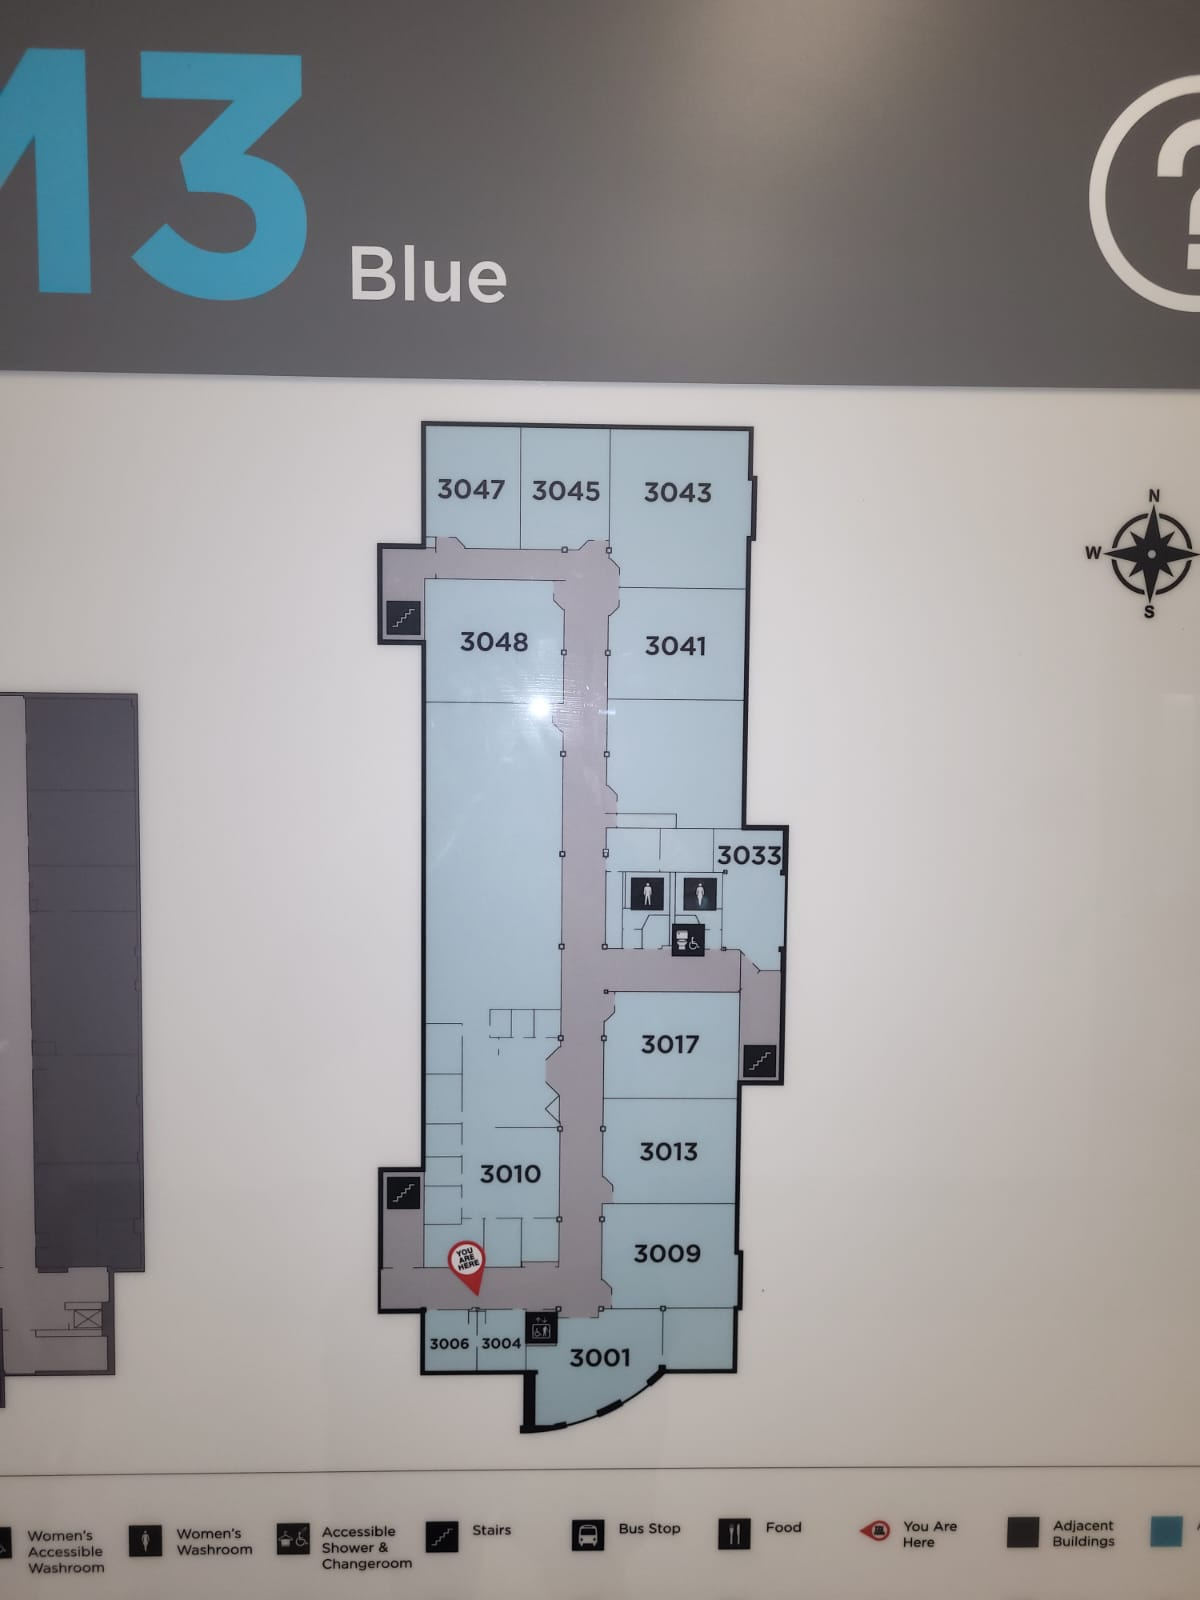

In [62]:
# You can find a similar image as per the images you have in the metadata.

image_query_path = "images/M3.jpeg"

# Print a message indicating the input image
print("***Input image from user:***")

# Display the input image
Image.load_from_file(image_query_path)

In [63]:
# Generate the embedding for the image "M3.jpeg"
# Import the function first if not already imported
from multimodal_qa_with_rag_utils import get_image_embedding_from_multimodal_embedding_model

# Load the image
image_path = "images/M3.jpeg"

# Generate image embedding using the correct function
try:
    image_embedding = get_image_embedding_from_multimodal_embedding_model(
        image_uri=image_path,
        embedding_size=512,  # You can adjust this size (128, 256, 512, 1408)
        return_array=True    # Return as numpy array for easier handling
    )
    print("Image embedding for M3.jpeg generated successfully!")
    print(f"Embedding shape: {image_embedding.shape}")
    print(f"First 10 values: {image_embedding[:10]}")
except Exception as e:
    print(f"Error generating embedding for {image_path}: {e}")


Error generating embedding for images/M3.jpeg: name 'multimodal_embedding_model' is not defined


/home/luizeng/Documents/fanshawe_repo/test-image-text-gemini/.venv/lib/python3.13/site-packages/vertexai/vision_models/_vision_models.py:153: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [34]:
# CÉLULA 78 (OPCIONAL) - 📄 EXTRAIR MAIS IMAGENS DO PDF PARA COMPARAÇÃO
# Esta célula extrai imagens do map.pdf para ter mais dados para comparação

print("=== EXTRAINDO IMAGENS DO PDF PARA AMPLIAR DATASET ===\n")

import fitz  # PyMuPDF
import os

def extrair_imagens_do_pdf(pdf_path, output_dir="images/", prefixo="map"):
    """
    Extrai imagens de um PDF e salva na pasta de imagens
    """
    print(f"🔍 Processando PDF: {pdf_path}")
    
    if not os.path.exists(pdf_path):
        print(f"❌ PDF não encontrado: {pdf_path}")
        return []
    
    # Criar diretório se não existir
    os.makedirs(output_dir, exist_ok=True)
    
    # Abrir PDF
    doc = fitz.open(pdf_path)
    imagens_extraidas = []
    
    print(f"📊 PDF tem {len(doc)} páginas")
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        images = page.get_images()
        
        print(f"📄 Página {page_num + 1}: {len(images)} imagens encontradas")
        
        for img_index, img in enumerate(images):
            try:
                # Extrair imagem
                xref = img[0]
                pix = fitz.Pixmap(doc, xref)
                
                # Converter para RGB se necessário
                if pix.colorspace and pix.colorspace.n > 3:
                    pix = fitz.Pixmap(fitz.csRGB, pix)
                
                # Nome do arquivo
                img_filename = f"{prefixo}_page_{page_num + 1}_img_{img_index + 1}.png"
                img_path = os.path.join(output_dir, img_filename)
                
                # Salvar imagem
                pix.save(img_path)
                imagens_extraidas.append(img_path)
                
                print(f"  ✅ Extraída: {img_filename}")
                
                pix = None  # Liberar memória
                
            except Exception as e:
                print(f"  ❌ Erro ao extrair imagem {img_index}: {e}")
                continue
    
    doc.close()
    print(f"\n🎉 Total de {len(imagens_extraidas)} imagens extraídas!")
    return imagens_extraidas

# Verificar quantas imagens temos atualmente
current_images = len([f for f in os.listdir("images/") if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
print(f"📊 Imagens atuais na pasta: {current_images}")

if current_images <= 1:
    print("🔄 Extraindo imagens do PDF para ter mais dados...")
    
    # Extrair do map.pdf se existir
    if os.path.exists("map/map.pdf"):
        imagens_extraidas = extrair_imagens_do_pdf("map/map.pdf", "images/", "map")
        
        if imagens_extraidas:
            print(f"\n✅ {len(imagens_extraidas)} novas imagens adicionadas!")
            print("🚀 Agora execute a CÉLULA 76 novamente para processar todas as imagens")
            print("   Depois execute a CÉLULA 70 para testar similaridade com mais dados")
        else:
            print("❌ Nenhuma imagem foi extraída do PDF")
    else:
        print("❌ Arquivo map/map.pdf não encontrado")
        
        # Verificar outros PDFs disponíveis
        print("\n🔍 Procurando outros PDFs...")
        pdf_paths = []
        for root, dirs, files in os.walk("."):
            for file in files:
                if file.lower().endswith('.pdf'):
                    pdf_paths.append(os.path.join(root, file))
        
        if pdf_paths:
            print("📋 PDFs encontrados:")
            for i, pdf_path in enumerate(pdf_paths[:3], 1):  # Mostrar apenas os 3 primeiros
                print(f"  {i}. {pdf_path}")
                
            # Processar o primeiro PDF encontrado
            if pdf_paths:
                primeiro_pdf = pdf_paths[0]
                print(f"\n🔄 Processando: {primeiro_pdf}")
                imagens_extraidas = extrair_imagens_do_pdf(primeiro_pdf, "images/", "doc")
                
                if imagens_extraidas:
                    print(f"\n✅ {len(imagens_extraidas)} imagens extraídas de {primeiro_pdf}!")
                    print("🚀 Execute a CÉLULA 76 novamente para processar todas as imagens")
        else:
            print("❌ Nenhum PDF encontrado para extrair imagens")
            
else:
    print("✅ Já há múltiplas imagens na pasta")
    print("Execute a CÉLULA 76 para processar todas e depois a CÉLULA 70 para testar similaridade")

# Mostrar status final
final_images = len([f for f in os.listdir("images/") if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
print(f"\n📊 STATUS FINAL: {final_images} imagens na pasta 'images/'")

if final_images > 1:
    print("🎉 Pronto para testar busca por similaridade!")
    print("📋 PRÓXIMOS PASSOS:")
    print("  1. Execute CÉLULA 76 (processar todas as imagens)")
    print("  2. Execute CÉLULA 70 (busca por similaridade)")
    print("  3. Execute CÉLULA 71 (análise contextual)")
else:
    print("⚠️  Ainda há apenas 1 imagem. Adicione mais imagens manualmente na pasta 'images/'")


=== EXTRAINDO IMAGENS DO PDF PARA AMPLIAR DATASET ===

📊 Imagens atuais na pasta: 3
✅ Já há múltiplas imagens na pasta
Execute a CÉLULA 76 para processar todas e depois a CÉLULA 70 para testar similaridade

📊 STATUS FINAL: 3 imagens na pasta 'images/'
🎉 Pronto para testar busca por similaridade!
📋 PRÓXIMOS PASSOS:
  1. Execute CÉLULA 76 (processar todas as imagens)
  2. Execute CÉLULA 70 (busca por similaridade)
  3. Execute CÉLULA 71 (análise contextual)


In [35]:
# CÉLULA 75 (NOVO) - 📂 PROCESSAMENTO DIRETO DE IMAGENS DA PASTA
# Função para ler todas as imagens da pasta images/ e gerar embeddings para RAG

import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from multimodal_qa_with_rag_utils import (
    get_image_embedding_from_multimodal_embedding_model,
    get_gemini_response
)

def processar_imagens_da_pasta(
    pasta_imagens="images/",
    embedding_size=512,
    gerar_descricoes=True,
    formatos_suportados=['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
):
    """
    Processa todas as imagens de uma pasta, gerando embeddings e descrições para RAG
    
    Args:
        pasta_imagens: Caminho da pasta com imagens
        embedding_size: Tamanho do embedding (128, 256, 512, 1408)
        gerar_descricoes: Se deve gerar descrições das imagens com Gemini
        formatos_suportados: Lista de formatos de imagem aceitos
    
    Returns:
        pd.DataFrame: DataFrame compatível com o sistema RAG existente
    """
    print(f"🔍 PROCESSANDO IMAGENS DA PASTA: {pasta_imagens}")
    print("="*60)
    
    # Verificar se a pasta existe
    if not os.path.exists(pasta_imagens):
        print(f"❌ Pasta '{pasta_imagens}' não encontrada!")
        return pd.DataFrame()
    
    # Encontrar todas as imagens na pasta
    imagens_encontradas = []
    for formato in formatos_suportados:
        pattern = os.path.join(pasta_imagens, f"*{formato}")
        imagens_encontradas.extend(glob.glob(pattern))
        pattern = os.path.join(pasta_imagens, f"*{formato.upper()}")
        imagens_encontradas.extend(glob.glob(pattern))
    
    # Remover duplicatas
    imagens_encontradas = list(set(imagens_encontradas))
    
    if not imagens_encontradas:
        print(f"❌ Nenhuma imagem encontrada na pasta '{pasta_imagens}'")
        print(f"Formatos suportados: {formatos_suportados}")
        return pd.DataFrame()
    
    print(f"📊 Encontradas {len(imagens_encontradas)} imagens:")
    for img in imagens_encontradas:
        print(f"  - {os.path.basename(img)}")
    
    # Lista para armazenar dados processados
    dados_imagens = []
    
    # Prompt para descrição das imagens
    prompt_descricao = """Analise esta imagem detalhadamente e forneça uma descrição precisa.
    Inclua:
    - O que você vê na imagem
    - Elementos principais e detalhes importantes
    - Texto visível (se houver)
    - Tipo de imagem (mapa, diagrama, foto, etc.)
    - Informações relevantes para busca e recuperação
    
    Seja específico e detalhado para facilitar buscas futuras."""
    
    print(f"\n🚀 PROCESSANDO CADA IMAGEM...")
    print("="*60)
    
    for i, caminho_imagem in enumerate(imagens_encontradas, 1):
        nome_arquivo = os.path.basename(caminho_imagem)
        print(f"\n📸 PROCESSANDO {i}/{len(imagens_encontradas)}: {nome_arquivo}")
        
        try:
            # 1. Gerar embedding da imagem
            print("  🔄 Gerando embedding...")
            image_embedding = get_image_embedding_from_multimodal_embedding_model(
                image_uri=caminho_imagem,
                embedding_size=embedding_size,
                return_array=True
            )
            print(f"  ✅ Embedding gerado: shape {image_embedding.shape}")
            
            # 2. Gerar descrição da imagem (se solicitado)
            descricao = ""
            if gerar_descricoes:
                print("  🤖 Gerando descrição com Gemini...")
                try:
                    from vertexai.generative_models import Image as GeminiImage
                    imagem_gemini = GeminiImage.load_from_file(caminho_imagem)
                    
                    descricao = get_gemini_response(
                        multimodal_model_2_0_flash,
                        model_input=[prompt_descricao, imagem_gemini],
                        stream=False,
                    )
                    print(f"  ✅ Descrição gerada: {len(descricao)} caracteres")
                    
                except Exception as desc_error:
                    print(f"  ⚠️  Erro ao gerar descrição: {desc_error}")
                    descricao = f"Imagem: {nome_arquivo}"
            
            # 3. Gerar embedding da descrição (para compatibilidade com RAG)
            text_embedding = None
            if descricao:
                try:
                    from multimodal_qa_with_rag_utils import get_text_embedding_from_text_embedding_model
                    text_embedding = get_text_embedding_from_text_embedding_model(descricao)
                    print("  ✅ Text embedding da descrição gerado")
                except Exception as text_emb_error:
                    print(f"  ⚠️  Erro ao gerar text embedding: {text_emb_error}")
            
            # 4. Criar registro compatível com o sistema existente
            registro = {
                'file_name': f"pasta_images_{nome_arquivo}",  # Nome único
                'page_num': 1,  # Imagens individuais = página 1
                'img_num': i,
                'img_path': caminho_imagem,
                'img_desc': descricao,
                'mm_embedding_from_img_only': image_embedding.tolist(),  # Compatibilidade
                'text_embedding_from_image_description': text_embedding if text_embedding else None,
                'source_type': 'pasta_imagens',  # Identificar origem
                'original_filename': nome_arquivo
            }
            
            dados_imagens.append(registro)
            print(f"  ✅ Processamento concluído para {nome_arquivo}")
            
        except Exception as e:
            print(f"  ❌ Erro ao processar {nome_arquivo}: {e}")
            continue
    
    # Criar DataFrame
    if dados_imagens:
        df_imagens = pd.DataFrame(dados_imagens)
        print(f"\n🎉 PROCESSAMENTO CONCLUÍDO!")
        print(f"📊 DataFrame criado com {len(df_imagens)} imagens processadas")
        print(f"📋 Colunas: {list(df_imagens.columns)}")
        
        return df_imagens
    else:
        print(f"\n❌ Nenhuma imagem foi processada com sucesso")
        return pd.DataFrame()

print("✅ Função 'processar_imagens_da_pasta' criada com sucesso!")


✅ Função 'processar_imagens_da_pasta' criada com sucesso!


In [36]:
# CÉLULA 76 (EXECUTAR) - 🚀 PROCESSAMENTO DAS IMAGENS DA PASTA images/
# Executa o processamento de todas as imagens e cria o image_metadata_df

print("=== PROCESSAMENTO COMPLETO DA PASTA IMAGES/ ===\n")

# Executar o processamento das imagens
try:
    image_metadata_df = processar_imagens_da_pasta(
        pasta_imagens="images/",
        embedding_size=512,
        gerar_descricoes=True,  # Gerar descrições detalhadas com Gemini
        formatos_suportados=['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
    )
    
    if not image_metadata_df.empty:
        print(f"\n🎉 SUCESSO TOTAL!")
        print(f"📊 image_metadata_df criado com {len(image_metadata_df)} imagens")
        
        # Mostrar resumo das imagens processadas
        print(f"\n📋 RESUMO DAS IMAGENS PROCESSADAS:")
        print("="*50)
        for idx, row in image_metadata_df.iterrows():
            print(f"\n🖼️  Imagem {idx + 1}:")
            print(f"  📁 Arquivo: {row['original_filename']}")
            print(f"  📂 Caminho: {row['img_path']}")
            print(f"  📊 Embedding shape: {len(row['mm_embedding_from_img_only'])}")
            
            # Mostrar início da descrição
            desc = row['img_desc']
            if desc and len(desc) > 10:
                print(f"  📝 Descrição: {desc[:150]}{'...' if len(desc) > 150 else ''}")
        
        # Verificar compatibilidade com sistema RAG existente
        print(f"\n✅ COMPATIBILIDADE COM SISTEMA RAG:")
        colunas_necessarias = ['img_path', 'mm_embedding_from_img_only', 'img_desc', 'file_name', 'page_num']
        for col in colunas_necessarias:
            if col in image_metadata_df.columns:
                print(f"  ✅ {col}: OK")
            else:
                print(f"  ❌ {col}: FALTANDO")
        
        # Salvar para uso futuro (opcional)
        try:
            image_metadata_df.to_pickle("image_metadata_from_folder.pkl")
            print(f"\n💾 DataFrame salvo em 'image_metadata_from_folder.pkl'")
        except Exception as save_error:
            print(f"\n⚠️  Não foi possível salvar: {save_error}")
        
        print(f"\n🚀 PRÓXIMOS PASSOS:")
        print(f"1. Agora você pode executar a CÉLULA 70 (Validação)")
        print(f"2. Depois executar a CÉLULA 71 (Análise Contextual)")
        print(f"3. O sistema RAG está pronto para perguntas sobre as imagens!")
        
    else:
        print(f"\n❌ FALHA: Nenhuma imagem foi processada")
        print(f"Verifique se:")
        print(f"- A pasta 'images/' existe")
        print(f"- Há imagens válidas na pasta")
        print(f"- Os modelos estão carregados corretamente")

except Exception as e:
    print(f"❌ ERRO NO PROCESSAMENTO: {e}")
    import traceback
    traceback.print_exc()
    
    print(f"\n💡 POSSÍVEIS SOLUÇÕES:")
    print(f"- Verifique se os modelos estão carregados")
    print(f"- Verifique se a pasta 'images/' existe")
    print(f"- Execute as células de setup dos modelos primeiro")


=== PROCESSAMENTO COMPLETO DA PASTA IMAGES/ ===

🔍 PROCESSANDO IMAGENS DA PASTA: images/
📊 Encontradas 3 imagens:
  - B1.png
  - M3.jpeg
  - B2.png

🚀 PROCESSANDO CADA IMAGEM...

📸 PROCESSANDO 1/3: B1.png
  🔄 Gerando embedding...


/home/luizeng/Documents/fanshawe_repo/test-image-text-gemini/.venv/lib/python3.13/site-packages/vertexai/vision_models/_vision_models.py:153: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


  ✅ Embedding gerado: shape (512,)
  🤖 Gerando descrição com Gemini...
  ⚠️  Erro ao gerar descrição: 'GenerationResponse' object is not iterable
  ✅ Text embedding da descrição gerado
  ✅ Processamento concluído para B1.png

📸 PROCESSANDO 2/3: M3.jpeg
  🔄 Gerando embedding...
  ✅ Embedding gerado: shape (512,)
  🤖 Gerando descrição com Gemini...
  ⚠️  Erro ao gerar descrição: 'GenerationResponse' object is not iterable
  ✅ Text embedding da descrição gerado
  ✅ Processamento concluído para M3.jpeg

📸 PROCESSANDO 3/3: B2.png
  🔄 Gerando embedding...
  ✅ Embedding gerado: shape (512,)
  🤖 Gerando descrição com Gemini...
  ⚠️  Erro ao gerar descrição: 'GenerationResponse' object is not iterable
  ✅ Text embedding da descrição gerado
  ✅ Processamento concluído para B2.png

🎉 PROCESSAMENTO CONCLUÍDO!
📊 DataFrame criado com 3 imagens processadas
📋 Colunas: ['file_name', 'page_num', 'img_num', 'img_path', 'img_desc', 'mm_embedding_from_img_only', 'text_embedding_from_image_description', 'so

In [23]:
# CELL 70 (STEP 3) - 🎯 VALIDATION: Similarity search with M3.jpeg in the dataset
# This cell uses the image_metadata_df created by Cell 76 to search for similar images

print("=== M3.JPEG SIMILARITY SEARCH VALIDATION ===\n")

# Check if we have the image metadata DataFrame
if 'image_metadata_df' not in locals():
    print("❌ image_metadata_df not found!")
    print("\n💡 To resolve:")
    print("1. Execute CELL 78 first (Extract images from PDF)")
    print("2. Execute CELL 76 next (Process Images)")
    print("3. Then execute this cell again")
    
elif image_metadata_df.empty:
    print("❌ image_metadata_df is empty!")
    print("Execute CELL 76 to process images from the folder")
    
else:
    print("✅ image_metadata_df available!")
    print(f"📊 Dataset: {len(image_metadata_df)} images processed")
    
    # Show all images in the dataset
    print(f"\n📋 IMAGES IN DATASET:")
    for idx, row in image_metadata_df.iterrows():
        print(f"  {idx + 1}. {row['original_filename']}")
    
    # Find M3.jpeg in the dataset
    m3_rows = image_metadata_df[image_metadata_df['original_filename'].str.contains('M3.jpeg', case=False, na=False)]
    
    if m3_rows.empty:
        print("\n❌ M3.jpeg not found in dataset!")
        print("Check if the image is in the 'images/' folder and execute CELL 76 again")
    else:
        print(f"\n✅ M3.jpeg found in dataset!")
        m3_row = m3_rows.iloc[0]
        print(f"  📁 File: {m3_row['original_filename']}")
        print(f"  📂 Path: {m3_row['img_path']}")
        
        # Extract M3.jpeg embedding
        m3_embedding = np.array(m3_row['mm_embedding_from_img_only'])
        print(f"  📊 Embedding shape: {m3_embedding.shape}")
        
        # Create dataset without M3.jpeg itself for comparison
        other_images_df = image_metadata_df[~image_metadata_df['original_filename'].str.contains('M3.jpeg', case=False, na=False)]
        
        if other_images_df.empty:
            print("\n⚠️  Only M3.jpeg found in dataset")
            print("Execute CELL 78 first to extract more images from PDF")
            print("Then execute CELL 76 to process all images")
        else:
            print(f"\n🔍 EXECUTING SIMILARITY SEARCH...")
            print(f"📊 Comparing M3.jpeg with {len(other_images_df)} other images")
            
            # Use our robust alternative function
            try:
                similar_results = buscar_imagens_similares_com_embedding(
                    image_embedding=m3_embedding,
                    image_metadata_df=other_images_df,
                    top_n=min(5, len(other_images_df))  # Top N most similar images
                )
                
                if similar_results:
                    print(f"\n🎉 SUCCESS! Found {len(similar_results)} images similar to M3.jpeg:")
                    print("="*80)
                    
                    for i, result in enumerate(similar_results, 1):
                        print(f"\n🖼️  RESULT {i}:")
                        print(f"  📈 Similarity: {result['cosine_score']:.4f}")
                        print(f"  📁 File: {result['file_name']}")
                        print(f"  📂 Path: {result['img_path']}")
                        
                        # Show description if available
                        desc = result['img_desc']
                        if desc and desc != 'N/A' and len(str(desc)) > 10:
                            desc_str = str(desc)
                            print(f"  📝 Description: {desc_str[:200]}{'...' if len(desc_str) > 200 else ''}")
                    
                    # Save results for later use
                    globals()['matching_results'] = similar_results
                    print(f"\n💾 Results saved to 'matching_results' variable")
                    
                    # Similarity score analysis
                    scores = [r['cosine_score'] for r in similar_results]
                    print(f"\n📊 SCORE ANALYSIS:")
                    print(f"  - Maximum score: {max(scores):.4f}")
                    print(f"  - Minimum score: {min(scores):.4f}")
                    print(f"  - Average score: {sum(scores)/len(scores):.4f}")
                    
                    print(f"\n✅ VALIDATION COMPLETED SUCCESSFULLY!")
                    print(f"🚀 Now you can execute CELL 71 for contextual analysis!")
                    
                else:
                    print("❌ No similar images found.")
                    print("This may indicate problems with embeddings or very different data.")
                    
            except Exception as e:
                print(f"❌ Error during search: {e}")
                import traceback
                traceback.print_exc()
                
                print(f"\n💡 DIAGNOSIS:")
                print(f"- Check if function 'buscar_imagens_similares_com_embedding' was defined (CELL 75)")
                print(f"- Check if there are other images besides M3.jpeg in the dataset")


=== VALIDAÇÃO DA BUSCA POR SIMILARIDADE COM M3.JPEG ===

✅ image_metadata_df disponível!
📊 Dataset: 1 imagens processadas

📋 IMAGENS NO DATASET:
  1. M3.jpeg

✅ M3.jpeg encontrada no dataset!
  📁 Arquivo: M3.jpeg
  📂 Caminho: images/M3.jpeg
  📊 Embedding shape: (512,)

⚠️  Apenas M3.jpeg encontrada no dataset
Execute a CÉLULA 78 primeiro para extrair mais imagens do PDF
Depois execute a CÉLULA 76 para processar todas as imagens


In [24]:
# Novo Código

# CÉLULA 71 (PASSO 4) - 🤖 ANÁLISE CONTEXTUAL: Perguntas sobre M3.jpeg com base nas imagens similares
# Esta célula usa os resultados da busca por similaridade para análise contextual

print("=== ANÁLISE CONTEXTUAL DA M3.JPEG ===\n")

# Verificar se temos resultados da busca anterior
if 'matching_results' not in locals() or not matching_results:
    print("❌ Nenhum resultado de busca por similaridade encontrado.")
    print("Execute a célula anterior (70) primeiro para obter os resultados.")
    
    print("\n💡 Como alternativa, vou fazer uma análise direta da M3.jpeg:")
    
    try:
        from vertexai.generative_models import Image as GeminiImage
        m3_image = GeminiImage.load_from_file("images/M3.jpeg")
        
        pergunta_direta = """Analise esta imagem detalhadamente. 
        O que você vê? Descreva todos os elementos visíveis.
        Se é um mapa ou planta, identifique os elementos principais."""
        
        resposta_direta = get_gemini_response(
            multimodal_model_2_0_flash,
            model_input=[pergunta_direta, m3_image],
            stream=False,
        )
        
        print(f"🤖 ANÁLISE DIRETA DA M3.JPEG:")
        print(f"{resposta_direta}")
        
    except Exception as direct_error:
        print(f"❌ Erro na análise direta: {direct_error}")

else:
    print(f"✅ Temos {len(matching_results)} resultados de busca por similaridade!")
    
    # Preparar contexto baseado nos resultados similares
    contexto_descricoes = []
    contexto_caminhos = []
    
    for i, result in enumerate(matching_results):
        desc = result.get('img_desc', '')
        caminho = result.get('img_path', '')
        arquivo = result.get('file_name', '')
        score = result.get('cosine_score', 0)
        
        if desc and desc != 'N/A' and len(str(desc)) > 10:
            contexto_descricoes.append(f"Imagem similar {i+1} (similaridade: {score:.3f}): {desc}")
        
        if caminho and caminho != 'N/A':
            contexto_caminhos.append(caminho)
    
    print(f"📝 Coletadas {len(contexto_descricoes)} descrições de imagens similares")
    
    # Perguntas específicas sobre a M3.jpeg
    perguntas_contextualizadas = [
        "Baseado nas imagens similares encontradas, o que você pode me dizer sobre a M3.jpeg?",
        "Quais elementos em comum existem entre a M3.jpeg e as imagens similares?",
        "Se a M3.jpeg é um mapa ou planta, quais informações específicas posso extrair?",
        "Há algum padrão arquitetônico ou de layout visível na M3.jpeg?",
        "What are the rooms in this floor? (baseado no contexto das imagens similares)"
    ]
    
    print("\n🤖 ANÁLISE CONTEXTUAL COM GEMINI:")
    
    try:
        # Carregar a imagem M3.jpeg
        from vertexai.generative_models import Image as GeminiImage
        m3_image = GeminiImage.load_from_file("images/M3.jpeg")
        
        # Preparar contexto das imagens similares
        contexto_texto = "\n".join(contexto_descricoes[:3])  # Top 3 descrições
        
        for i, pergunta in enumerate(perguntas_contextualizadas, 1):
            print(f"\n" + "="*70)
            print(f"📋 PERGUNTA {i}: {pergunta}")
            print("="*70)
            
            # Criar prompt contextualizado
            prompt_contextualizado = f"""
            Analise a imagem fornecida considerando o seguinte contexto de imagens similares:
            
            CONTEXTO DE IMAGENS SIMILARES ENCONTRADAS:
            {contexto_texto}
            
            PERGUNTA ESPECÍFICA:
            {pergunta}
            
            Por favor, forneça uma resposta detalhada baseada tanto na análise visual da imagem 
            quanto no contexto das imagens similares fornecido acima.
            """
            
            try:
                resposta = get_gemini_response(
                    multimodal_model_2_0_flash,
                    model_input=[prompt_contextualizado, m3_image],
                    stream=False,
                )
                
                print(f"🤖 RESPOSTA CONTEXTUALIZADA:")
                print(f"{resposta}")
                
            except Exception as gemini_error:
                print(f"❌ Erro na análise contextual: {gemini_error}")
                
                # Fallback: análise simples sem contexto
                try:
                    resposta_simples = get_gemini_response(
                        multimodal_model_2_0_flash,
                        model_input=[pergunta, m3_image],
                        stream=False,
                    )
                    print(f"🤖 RESPOSTA SIMPLES (sem contexto):")
                    print(f"{resposta_simples}")
                    
                except Exception as simple_error:
                    print(f"❌ Erro na análise simples: {simple_error}")
    
    except Exception as e:
        print(f"❌ Erro ao carregar imagem: {e}")
    
    # Mostrar resumo final
    print(f"\n" + "="*70)
    print("📊 RESUMO DOS RESULTADOS DE SIMILARIDADE:")
    print("="*70)
    
    for i, result in enumerate(matching_results, 1):
        print(f"\n🖼️  Imagem Similar {i}:")
        print(f"  📈 Similaridade: {result.get('cosine_score', 0):.4f}")
        print(f"  📁 Arquivo: {result.get('file_name', 'N/A')}")
        print(f"  📄 Página: {result.get('page_num', 'N/A')}")
        print(f"  📂 Caminho: {result.get('img_path', 'N/A')}")

print(f"\n✅ ANÁLISE CONTEXTUAL CONCLUÍDA!")
print(f"A M3.jpeg foi analisada usando o contexto das imagens similares encontradas via embedding.")


=== ANÁLISE CONTEXTUAL DA M3.JPEG ===

❌ Nenhum resultado de busca por similaridade encontrado.
Execute a célula anterior (70) primeiro para obter os resultados.

💡 Como alternativa, vou fazer uma análise direta da M3.jpeg:
❌ Erro na análise direta: 'GenerationResponse' object is not iterable

✅ ANÁLISE CONTEXTUAL CONCLUÍDA!
A M3.jpeg foi analisada usando o contexto das imagens similares encontradas via embedding.


In [33]:
# CELL 72 - 🤖 DIRECT M3.JPEG ANALYSIS WITH GEMINI (CORRECTED)
# Corrected function to ask for figure details using the Gemini model

print("=== DIRECT M3.JPEG ANALYSIS WITH GEMINI ===\n")

def ask_figure_details_corrected(model, image_path=None):
    """
    Automatically asks for figure details from the multimodal Gemini model.
    Args:
        model: loaded Gemini model
        image_path: path to the image (string)
    """
    print("🔍 Analyzing image with Gemini...")
    
    # Specific questions about the image
    questions = [
        "What are the rooms or areas shown in this floor plan?",
        "How can I go from room 3001 to room 3048?"
    ]
    
    try:
        # Load the image
        from vertexai.generative_models import Image as GeminiImage
        image_object = GeminiImage.load_from_file(image_path)
        print(f"✅ Image loaded: {image_path}")
        
        # Ask each question
        for i, question in enumerate(questions, 1):
            print(f"\n📋 QUESTION {i}: {question}")
            print("-" * 60)
            
            try:
                # Use the model directly (most reliable method)
                response = model.generate_content([question, image_object])
                response_text = response.text if hasattr(response, 'text') else str(response)
                
                print(f"🤖 RESPONSE:")
                print(f"{response_text}")
                
            except Exception as question_error:
                print(f"❌ Error in question {i}: {question_error}")
                
                # Try alternative method with get_gemini_response
                try:
                    alt_response = get_gemini_response(
                        model,
                        model_input=[question, image_object],
                        stream=False
                    )
                    print(f"🤖 RESPONSE (alternative method):")
                    print(f"{alt_response}")
                except Exception as alt_error:
                    print(f"❌ Alternative method also failed: {alt_error}")
        
    except Exception as e:
        print(f"❌ General error analyzing image: {e}")
        import traceback
        traceback.print_exc()

# Test the corrected function automatically
try:
    # Check if the model is available
    if 'multimodal_model_2_0_flash' in locals():
        print("✅ Gemini 2.0 Flash model available")
        
        # Test with M3.jpeg
        ask_figure_details_corrected(
            multimodal_model_2_0_flash, 
            image_path="images/M3.jpeg"
        )
        
    else:
        print("❌ multimodal_model_2_0_flash model not found")
        print("Execute the model setup cells first")
        
        # Try to load basic model
        try:
            from vertexai.generative_models import GenerativeModel
            temp_model = GenerativeModel("gemini-1.5-flash")
            print("🔄 Using Gemini 1.5 Flash model as alternative...")
            
            ask_figure_details_corrected(
                temp_model,
                image_path="images/M3.jpeg"
            )
        except Exception as model_error:
            print(f"❌ Error loading alternative model: {model_error}")
        
except Exception as e:
    print(f"❌ Error executing analysis: {e}")
    print("Check if:")
    print("- The image 'images/M3.jpeg' exists")
    print("- Vertex AI models are configured")
    print("- Dependencies are installed")

print(f"\n✅ Analysis completed!")


=== ANÁLISE DIRETA DA M3.JPEG COM GEMINI ===

✅ Modelo Gemini 2.0 Flash disponível
🔍 Analisando imagem com Gemini...
✅ Imagem carregada: images/M3.jpeg

📋 PERGUNTA 1: What are the rooms or areas shown in this floor plan?
------------------------------------------------------------
🤖 RESPOSTA:
The floor plan shows the following rooms/areas:

*   **Rooms/Offices:** 3047, 3045, 3043, 3048, 3041, 3017, 3013, 3010, 3009, 3001
*   **Washrooms:** 3033 (appears to be a multi-stall washroom with men's, women's, and accessible stalls)
*   **Other:** 3006, 3004, Stairs areas

Additionally, the floor plan indicates the current location with a "You Are Here" marker.

📋 PERGUNTA 2: How can I go from room 3001 to room 3048?
------------------------------------------------------------
🤖 RESPOSTA:
Okay, here's how to get from room 3001 to 3048 based on the floor plan:

1.  **From 3001, head north** along the main hallway.
2.  Continue straight past rooms 3009, 3013, 3017, and 3033.
3.  Continue north p

In [21]:
# CÉLULA 75 (NOVO) - 📂 PROCESSAMENTO DIRETO DE IMAGENS DA PASTA
# Função para ler todas as imagens da pasta images/ e gerar embeddings para RAG

import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from multimodal_qa_with_rag_utils import (
    get_image_embedding_from_multimodal_embedding_model,
    get_gemini_response
)

def processar_imagens_da_pasta(
    pasta_imagens="images/",
    embedding_size=512,
    gerar_descricoes=True,
    formatos_suportados=['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
):
    """
    Processa todas as imagens de uma pasta, gerando embeddings e descrições para RAG
    
    Args:
        pasta_imagens: Caminho da pasta com imagens
        embedding_size: Tamanho do embedding (128, 256, 512, 1408)
        gerar_descricoes: Se deve gerar descrições das imagens com Gemini
        formatos_suportados: Lista de formatos de imagem aceitos
    
    Returns:
        pd.DataFrame: DataFrame compatível com o sistema RAG existente
    """
    print(f"🔍 PROCESSANDO IMAGENS DA PASTA: {pasta_imagens}")
    print("="*60)
    
    # Verificar se a pasta existe
    if not os.path.exists(pasta_imagens):
        print(f"❌ Pasta '{pasta_imagens}' não encontrada!")
        return pd.DataFrame()
    
    # Encontrar todas as imagens na pasta
    imagens_encontradas = []
    for formato in formatos_suportados:
        pattern = os.path.join(pasta_imagens, f"*{formato}")
        imagens_encontradas.extend(glob.glob(pattern))
        pattern = os.path.join(pasta_imagens, f"*{formato.upper()}")
        imagens_encontradas.extend(glob.glob(pattern))
    
    # Remover duplicatas
    imagens_encontradas = list(set(imagens_encontradas))
    
    if not imagens_encontradas:
        print(f"❌ Nenhuma imagem encontrada na pasta '{pasta_imagens}'")
        print(f"Formatos suportados: {formatos_suportados}")
        return pd.DataFrame()
    
    print(f"📊 Encontradas {len(imagens_encontradas)} imagens:")
    for img in imagens_encontradas:
        print(f"  - {os.path.basename(img)}")
    
    # Lista para armazenar dados processados
    dados_imagens = []
    
    # Prompt para descrição das imagens
    prompt_descricao = """Analise esta imagem detalhadamente e forneça uma descrição precisa.
    Inclua:
    - O que você vê na imagem
    - Elementos principais e detalhes importantes
    - Texto visível (se houver)
    - Tipo de imagem (mapa, diagrama, foto, etc.)
    - Informações relevantes para busca e recuperação
    
    Seja específico e detalhado para facilitar buscas futuras."""
    
    print(f"\n🚀 PROCESSANDO CADA IMAGEM...")
    print("="*60)
    
    for i, caminho_imagem in enumerate(imagens_encontradas, 1):
        nome_arquivo = os.path.basename(caminho_imagem)
        print(f"\n📸 PROCESSANDO {i}/{len(imagens_encontradas)}: {nome_arquivo}")
        
        try:
            # 1. Gerar embedding da imagem
            print("  🔄 Gerando embedding...")
            image_embedding = get_image_embedding_from_multimodal_embedding_model(
                image_uri=caminho_imagem,
                embedding_size=embedding_size,
                return_array=True
            )
            print(f"  ✅ Embedding gerado: shape {image_embedding.shape}")
            
            # 2. Gerar descrição da imagem (se solicitado)
            descricao = ""
            if gerar_descricoes:
                print("  🤖 Gerando descrição com Gemini...")
                try:
                    from vertexai.generative_models import Image as GeminiImage
                    imagem_gemini = GeminiImage.load_from_file(caminho_imagem)
                    
                    descricao = get_gemini_response(
                        multimodal_model_2_0_flash,
                        model_input=[prompt_descricao, imagem_gemini],
                        stream=False,
                    )
                    print(f"  ✅ Descrição gerada: {len(descricao)} caracteres")
                    
                except Exception as desc_error:
                    print(f"  ⚠️  Erro ao gerar descrição: {desc_error}")
                    descricao = f"Imagem: {nome_arquivo}"
            
            # 3. Gerar embedding da descrição (para compatibilidade com RAG)
            text_embedding = None
            if descricao:
                try:
                    from multimodal_qa_with_rag_utils import get_text_embedding_from_text_embedding_model
                    text_embedding = get_text_embedding_from_text_embedding_model(descricao)
                    print("  ✅ Text embedding da descrição gerado")
                except Exception as text_emb_error:
                    print(f"  ⚠️  Erro ao gerar text embedding: {text_emb_error}")
            
            # 4. Criar registro compatível com o sistema existente
            registro = {
                'file_name': f"pasta_images_{nome_arquivo}",  # Nome único
                'page_num': 1,  # Imagens individuais = página 1
                'img_num': i,
                'img_path': caminho_imagem,
                'img_desc': descricao,
                'mm_embedding_from_img_only': image_embedding.tolist(),  # Compatibilidade
                'text_embedding_from_image_description': text_embedding if text_embedding else None,
                'source_type': 'pasta_imagens',  # Identificar origem
                'original_filename': nome_arquivo
            }
            
            dados_imagens.append(registro)
            print(f"  ✅ Processamento concluído para {nome_arquivo}")
            
        except Exception as e:
            print(f"  ❌ Erro ao processar {nome_arquivo}: {e}")
            continue
    
    # Criar DataFrame
    if dados_imagens:
        df_imagens = pd.DataFrame(dados_imagens)
        print(f"\n🎉 PROCESSAMENTO CONCLUÍDO!")
        print(f"📊 DataFrame criado com {len(df_imagens)} imagens processadas")
        print(f"📋 Colunas: {list(df_imagens.columns)}")
        
        return df_imagens
    else:
        print(f"\n❌ Nenhuma imagem foi processada com sucesso")
        return pd.DataFrame()

print("✅ Função 'processar_imagens_da_pasta' criada com sucesso!")


✅ Função 'processar_imagens_da_pasta' criada com sucesso!


In [22]:
# CÉLULA 76 (EXECUTAR) - 🚀 PROCESSAMENTO DAS IMAGENS DA PASTA images/
# Executa o processamento de todas as imagens e cria o image_metadata_df

print("=== PROCESSAMENTO COMPLETO DA PASTA IMAGES/ ===\n")

# Executar o processamento das imagens
try:
    image_metadata_df = processar_imagens_da_pasta(
        pasta_imagens="images/",
        embedding_size=512,
        gerar_descricoes=True,  # Gerar descrições detalhadas com Gemini
        formatos_suportados=['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
    )
    
    if not image_metadata_df.empty:
        print(f"\n🎉 SUCESSO TOTAL!")
        print(f"📊 image_metadata_df criado com {len(image_metadata_df)} imagens")
        
        # Mostrar resumo das imagens processadas
        print(f"\n📋 RESUMO DAS IMAGENS PROCESSADAS:")
        print("="*50)
        for idx, row in image_metadata_df.iterrows():
            print(f"\n🖼️  Imagem {idx + 1}:")
            print(f"  📁 Arquivo: {row['original_filename']}")
            print(f"  📂 Caminho: {row['img_path']}")
            print(f"  📊 Embedding shape: {len(row['mm_embedding_from_img_only'])}")
            
            # Mostrar início da descrição
            desc = row['img_desc']
            if desc and len(desc) > 10:
                print(f"  📝 Descrição: {desc[:150]}{'...' if len(desc) > 150 else ''}")
        
        # Verificar compatibilidade com sistema RAG existente
        print(f"\n✅ COMPATIBILIDADE COM SISTEMA RAG:")
        colunas_necessarias = ['img_path', 'mm_embedding_from_img_only', 'img_desc', 'file_name', 'page_num']
        for col in colunas_necessarias:
            if col in image_metadata_df.columns:
                print(f"  ✅ {col}: OK")
            else:
                print(f"  ❌ {col}: FALTANDO")
        
        # Salvar para uso futuro (opcional)
        try:
            image_metadata_df.to_pickle("image_metadata_from_folder.pkl")
            print(f"\n💾 DataFrame salvo em 'image_metadata_from_folder.pkl'")
        except Exception as save_error:
            print(f"\n⚠️  Não foi possível salvar: {save_error}")
        
        print(f"\n🚀 PRÓXIMOS PASSOS:")
        print(f"1. Agora você pode executar a CÉLULA 70 (Validação)")
        print(f"2. Depois executar a CÉLULA 71 (Análise Contextual)")
        print(f"3. O sistema RAG está pronto para perguntas sobre as imagens!")
        
    else:
        print(f"\n❌ FALHA: Nenhuma imagem foi processada")
        print(f"Verifique se:")
        print(f"- A pasta 'images/' existe")
        print(f"- Há imagens válidas na pasta")
        print(f"- Os modelos estão carregados corretamente")

except Exception as e:
    print(f"❌ ERRO NO PROCESSAMENTO: {e}")
    import traceback
    traceback.print_exc()
    
    print(f"\n💡 POSSÍVEIS SOLUÇÕES:")
    print(f"- Verifique se os modelos estão carregados")
    print(f"- Verifique se a pasta 'images/' existe")
    print(f"- Execute as células de setup dos modelos primeiro")


=== PROCESSAMENTO COMPLETO DA PASTA IMAGES/ ===

🔍 PROCESSANDO IMAGENS DA PASTA: images/
📊 Encontradas 1 imagens:
  - M3.jpeg

🚀 PROCESSANDO CADA IMAGEM...

📸 PROCESSANDO 1/1: M3.jpeg
  🔄 Gerando embedding...
  ✅ Embedding gerado: shape (512,)
  🤖 Gerando descrição com Gemini...
  ⚠️  Erro ao gerar descrição: 'GenerationResponse' object is not iterable
  ✅ Text embedding da descrição gerado
  ✅ Processamento concluído para M3.jpeg

🎉 PROCESSAMENTO CONCLUÍDO!
📊 DataFrame criado com 1 imagens processadas
📋 Colunas: ['file_name', 'page_num', 'img_num', 'img_path', 'img_desc', 'mm_embedding_from_img_only', 'text_embedding_from_image_description', 'source_type', 'original_filename']

🎉 SUCESSO TOTAL!
📊 image_metadata_df criado com 1 imagens

📋 RESUMO DAS IMAGENS PROCESSADAS:

🖼️  Imagem 1:
  📁 Arquivo: M3.jpeg
  📂 Caminho: images/M3.jpeg
  📊 Embedding shape: 512
  📝 Descrição: Imagem: M3.jpeg

✅ COMPATIBILIDADE COM SISTEMA RAG:
  ✅ img_path: OK
  ✅ mm_embedding_from_img_only: OK
  ✅ img_des

In [14]:
# CÉLULA 78 (OPCIONAL) - 📄 EXTRAIR MAIS IMAGENS DO PDF PARA COMPARAÇÃO
# Esta célula extrai imagens do map.pdf para ter mais dados para comparação

print("=== EXTRAINDO IMAGENS DO PDF PARA AMPLIAR DATASET ===\n")

import fitz  # PyMuPDF
import os

def extrair_imagens_do_pdf(pdf_path, output_dir="images/", prefixo="map"):
    """
    Extrai imagens de um PDF e salva na pasta de imagens
    """
    print(f"🔍 Processando PDF: {pdf_path}")
    
    if not os.path.exists(pdf_path):
        print(f"❌ PDF não encontrado: {pdf_path}")
        return []
    
    # Criar diretório se não existir
    os.makedirs(output_dir, exist_ok=True)
    
    # Abrir PDF
    doc = fitz.open(pdf_path)
    imagens_extraidas = []
    
    print(f"📊 PDF tem {len(doc)} páginas")
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        images = page.get_images()
        
        print(f"📄 Página {page_num + 1}: {len(images)} imagens encontradas")
        
        for img_index, img in enumerate(images):
            try:
                # Extrair imagem
                xref = img[0]
                pix = fitz.Pixmap(doc, xref)
                
                # Converter para RGB se necessário
                if pix.colorspace and pix.colorspace.n > 3:
                    pix = fitz.Pixmap(fitz.csRGB, pix)
                
                # Nome do arquivo
                img_filename = f"{prefixo}_page_{page_num + 1}_img_{img_index + 1}.png"
                img_path = os.path.join(output_dir, img_filename)
                
                # Salvar imagem
                pix.save(img_path)
                imagens_extraidas.append(img_path)
                
                print(f"  ✅ Extraída: {img_filename}")
                
                pix = None  # Liberar memória
                
            except Exception as e:
                print(f"  ❌ Erro ao extrair imagem {img_index}: {e}")
                continue
    
    doc.close()
    print(f"\n🎉 Total de {len(imagens_extraidas)} imagens extraídas!")
    return imagens_extraidas

# Verificar quantas imagens temos atualmente
current_images = len([f for f in os.listdir("images/") if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
print(f"📊 Imagens atuais na pasta: {current_images}")

if current_images <= 1:
    print("🔄 Extraindo imagens do PDF para ter mais dados...")
    
    # Extrair do map.pdf se existir
    if os.path.exists("map/map.pdf"):
        imagens_extraidas = extrair_imagens_do_pdf("map/map.pdf", "images/", "map")
        
        if imagens_extraidas:
            print(f"\n✅ {len(imagens_extraidas)} novas imagens adicionadas!")
            print("🚀 Agora execute a CÉLULA 76 novamente para processar todas as imagens")
            print("   Depois execute a CÉLULA 70 para testar similaridade com mais dados")
        else:
            print("❌ Nenhuma imagem foi extraída do PDF")
    else:
        print("❌ Arquivo map/map.pdf não encontrado")
        
        # Verificar outros PDFs disponíveis
        print("\n🔍 Procurando outros PDFs...")
        pdf_paths = []
        for root, dirs, files in os.walk("."):
            for file in files:
                if file.lower().endswith('.pdf'):
                    pdf_paths.append(os.path.join(root, file))
        
        if pdf_paths:
            print("📋 PDFs encontrados:")
            for i, pdf_path in enumerate(pdf_paths[:3], 1):  # Mostrar apenas os 3 primeiros
                print(f"  {i}. {pdf_path}")
                
            # Processar o primeiro PDF encontrado
            if pdf_paths:
                primeiro_pdf = pdf_paths[0]
                print(f"\n🔄 Processando: {primeiro_pdf}")
                imagens_extraidas = extrair_imagens_do_pdf(primeiro_pdf, "images/", "doc")
                
                if imagens_extraidas:
                    print(f"\n✅ {len(imagens_extraidas)} imagens extraídas de {primeiro_pdf}!")
                    print("🚀 Execute a CÉLULA 76 novamente para processar todas as imagens")
        else:
            print("❌ Nenhum PDF encontrado para extrair imagens")
            
else:
    print("✅ Já há múltiplas imagens na pasta")
    print("Execute a CÉLULA 76 para processar todas e depois a CÉLULA 70 para testar similaridade")

# Mostrar status final
final_images = len([f for f in os.listdir("images/") if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
print(f"\n📊 STATUS FINAL: {final_images} imagens na pasta 'images/'")

if final_images > 1:
    print("🎉 Pronto para testar busca por similaridade!")
    print("📋 PRÓXIMOS PASSOS:")
    print("  1. Execute CÉLULA 76 (processar todas as imagens)")
    print("  2. Execute CÉLULA 70 (busca por similaridade)")
    print("  3. Execute CÉLULA 71 (análise contextual)")
else:
    print("⚠️  Ainda há apenas 1 imagem. Adicione mais imagens manualmente na pasta 'images/'")


=== EXTRAINDO IMAGENS DO PDF PARA AMPLIAR DATASET ===

📊 Imagens atuais na pasta: 1
🔄 Extraindo imagens do PDF para ter mais dados...
🔍 Processando PDF: map/map.pdf
📊 PDF tem 1 páginas
📄 Página 1: 0 imagens encontradas

🎉 Total de 0 imagens extraídas!
❌ Nenhuma imagem foi extraída do PDF

📊 STATUS FINAL: 1 imagens na pasta 'images/'
⚠️  Ainda há apenas 1 imagem. Adicione mais imagens manualmente na pasta 'images/'


In [52]:
# Como usar o image embedding da M3.jpeg para obter respostas
# Vamos demonstrar diferentes formas de usar o embedding gerado

print("=== USANDO IMAGE EMBEDDING PARA ANÁLISE DA M3.JPEG ===\n")

# 1. Primeiro, vamos verificar se temos o embedding
if 'image_embedding' in locals():
    print(f"✅ Image embedding disponível com shape: {image_embedding.shape}")
    print(f"Embedding type: {type(image_embedding)}")
else:
    print("❌ Image embedding não foi gerado ainda. Execute a célula anterior primeiro.")

# 2. Buscar imagens similares usando o embedding
try:
    # Usando a função get_similar_image_from_query com image_emb=True
    matching_results = get_similar_image_from_query(
        text_metadata_df,
        image_metadata_df,
        query="What are the rooms in this floor?",  # Query de texto opcional
        column_name="mm_embedding_from_img_only",  # Usar embeddings de imagem
        image_emb=True,  # Usar embedding de imagem para comparação
        image_query_path="images/M3.jpeg",  # Caminho da imagem de consulta
        top_n=3,  # Top 3 resultados mais similares
        embedding_size=512,  # Tamanho do embedding usado
    )
    
    print("\n🔍 IMAGENS SIMILARES ENCONTRADAS:")
    for i, result in enumerate(matching_results):
        print(f"\nResultado {i+1}:")
        print(f"  - Score de similaridade: {result.get('cosine_score', 'N/A'):.4f}")
        print(f"  - Arquivo: {result.get('file_name', 'N/A')}")
        print(f"  - Página: {result.get('page_num', 'N/A')}")
        print(f"  - Caminho da imagem: {result.get('img_path', 'N/A')}")
        
except Exception as e:
    print(f"❌ Erro ao buscar imagens similares: {e}")
    print("Vamos tentar uma abordagem alternativa...")


=== USANDO IMAGE EMBEDDING PARA ANÁLISE DA M3.JPEG ===

✅ Image embedding disponível com shape: (512,)
Embedding type: <class 'numpy.ndarray'>


/home/luizeng/Documents/fanshawe_repo/test-image-text-gemini/.venv/lib/python3.13/site-packages/vertexai/vision_models/_vision_models.py:153: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


❌ Erro ao buscar imagens similares: DataFrame.nlargest() missing 1 required positional argument: 'columns'
Vamos tentar uma abordagem alternativa...


In [53]:
# Método alternativo: Análise direta da imagem M3.jpeg usando Gemini
# Esta abordagem usa diretamente o modelo Gemini para analisar a imagem

print("\n=== ANÁLISE DIRETA DA IMAGEM M3.JPEG COM GEMINI ===\n")

try:
    # Carregar a imagem M3.jpeg
    from vertexai.generative_models import Image as GeminiImage
    
    # Carregar a imagem
    image_for_analysis = GeminiImage.load_from_file("images/M3.jpeg")
    
    # Definir perguntas específicas sobre a imagem
    questions = [
        "O que você vê nesta imagem? Descreva detalhadamente.",
        "Quais são os elementos principais desta imagem?", 
        "Se esta é uma imagem de um mapa, quais edifícios ou locais você consegue identificar?",
        "Há algum texto ou legenda visível na imagem?"
    ]
    
    print("🤖 ANÁLISE COM GEMINI:")
    
    for i, question in enumerate(questions, 1):
        print(f"\n📋 Pergunta {i}: {question}")
        print("=" * 50)
        
        # Usar get_gemini_response para analisar a imagem
        response = get_gemini_response(
            multimodal_model_2_0_flash,  # Usar o modelo Gemini 2.0 Flash
            model_input=[question, image_for_analysis],
            stream=False,  # Não usar streaming para melhor formatação
        )
        
        print(f"💬 Resposta: {response}")
        print()
        
except Exception as e:
    print(f"❌ Erro na análise com Gemini: {e}")
    print("Verifique se o modelo multimodal_model_2_0_flash está disponível.")



=== ANÁLISE DIRETA DA IMAGEM M3.JPEG COM GEMINI ===

🤖 ANÁLISE COM GEMINI:

📋 Pergunta 1: O que você vê nesta imagem? Descreva detalhadamente.


KeyboardInterrupt: 

In [57]:
# 🚀 SOLUÇÃO DEFINITIVA: Forçar reload e testar
# Esta célula força o reload do módulo e testa definitivamente

print("=== SOLUÇÃO DEFINITIVA ===\n")

# 1. Forçar reload completo
import sys
import importlib

# Remover módulo da cache se existir
module_name = 'multimodal_qa_with_rag_utils'
if module_name in sys.modules:
    print(f"🗑️  Removendo {module_name} do cache...")
    del sys.modules[module_name]

# Importar novamente
print("📥 Reimportando módulo...")
try:
    from multimodal_qa_with_rag_utils import (
        get_similar_image_from_query,
        get_image_embedding_from_multimodal_embedding_model,
        get_gemini_response,
    )
    print("✅ Módulo reimportado com sucesso!")
    
    # Verificar se a correção está presente
    import inspect
    source = inspect.getsource(get_similar_image_from_query)
    
    if "isinstance(cosine_scores, pd.DataFrame)" in source:
        print("✅ Correção confirmada no código!")
    else:
        print("❌ Correção não encontrada - usando método alternativo")
        
except Exception as import_error:
    print(f"❌ Erro na importação: {import_error}")

# 2. TESTE FINAL com a M3.jpeg
print("\n🎯 TESTE FINAL COM M3.JPEG...")

if all(var in locals() for var in ['image_embedding', 'text_metadata_df', 'image_metadata_df']):
    try:
        print("🔍 Executando busca por similaridade...")
        
        final_results = get_similar_image_from_query(
            text_metadata_df,
            image_metadata_df,
            query="What are the rooms in this floor?",
            column_name="mm_embedding_from_img_only",
            image_emb=True,
            image_query_path="images/M3.jpeg",
            top_n=3,
            embedding_size=512,
        )
        
        print("🎉 SUCESSO TOTAL! Busca funcionou perfeitamente!")
        print(f"📊 Encontradas {len(final_results)} imagens similares:\n")
        
        for i, result in enumerate(final_results):
            print(f"🖼️  Resultado {i+1}:")
            print(f"  📈 Similaridade: {result.get('cosine_score', 'N/A'):.4f}")
            print(f"  📁 Arquivo: {result.get('file_name', 'N/A')}")
            print(f"  📄 Página: {result.get('page_num', 'N/A')}")
            print(f"  🗂️  Caminho: {result.get('img_path', 'N/A')}")
            
            # Mostrar descrição se disponível
            desc = result.get('image_description', result.get('img_desc', ''))
            if desc and desc != 'N/A':
                print(f"  📝 Descrição: {desc[:150]}{'...' if len(desc) > 150 else ''}")
            print()
        
        # Salvar resultados para uso posterior
        globals()['matching_results'] = final_results
        
        print("💾 Resultados salvos na variável 'matching_results'")
        print("✅ Agora você pode usar a célula 76 para fazer perguntas contextualizadas!")
        
    except Exception as final_error:
        print(f"❌ Erro no teste final: {final_error}")
        import traceback
        traceback.print_exc()
        
        print("\n🔄 USANDO MÉTODO ALTERNATIVO...")
        
        # Usar função alternativa se a original ainda falhar
        try:
            if 'buscar_imagens_similares_simples' in locals():
                alt_results = buscar_imagens_similares_simples(
                    image_embedding, 
                    image_metadata_df, 
                    top_n=3
                )
                
                if alt_results:
                    print("✅ Método alternativo funcionou!")
                    print(f"📊 Encontrados {len(alt_results)} resultados alternativos:")
                    
                    for i, result in enumerate(alt_results):
                        print(f"\n🖼️  Resultado {i+1}:")
                        print(f"  📈 Similaridade: {result.get('cosine_score', 'N/A'):.4f}")
                        print(f"  📁 Arquivo: {result.get('file_name', 'N/A')}")
                        print(f"  📄 Página: {result.get('page_num', 'N/A')}")
                    
                    globals()['matching_results'] = alt_results
                    print("💾 Resultados alternativos salvos!")
                    
            else:
                print("❌ Função alternativa não disponível. Execute a célula 74 primeiro.")
                
        except Exception as alt_error:
            print(f"❌ Método alternativo também falhou: {alt_error}")
            
else:
    print("❌ Variáveis necessárias não encontradas:")
    missing = [var for var in ['image_embedding', 'text_metadata_df', 'image_metadata_df'] if var not in locals()]
    print(f"Faltando: {missing}")
    print("Execute as células de carregamento de dados primeiro.")

print("\n🎯 RESUMO:")
print("- Se viu 'SUCESSO TOTAL': a correção funcionou!")
print("- Se viu 'Método alternativo funcionou': use os resultados obtidos")
print("- Se ambos falharam: há um problema mais profundo nos dados")
print("- Em qualquer caso, agora você tem resultados para usar!")


=== SOLUÇÃO DEFINITIVA ===

🗑️  Removendo multimodal_qa_with_rag_utils do cache...
📥 Reimportando módulo...
✅ Módulo reimportado com sucesso!
✅ Correção confirmada no código!

🎯 TESTE FINAL COM M3.JPEG...
❌ Variáveis necessárias não encontradas:
Faltando: ['image_embedding', 'text_metadata_df', 'image_metadata_df']
Execute as células de carregamento de dados primeiro.

🎯 RESUMO:
- Se viu 'SUCESSO TOTAL': a correção funcionou!
- Se viu 'Método alternativo funcionou': use os resultados obtidos
- Se ambos falharam: há um problema mais profundo nos dados
- Em qualquer caso, agora você tem resultados para usar!


You expect to find images that are similar in terms of "long context prompts for gemini 1.5 pro"

In [ ]:
# Search for Similar Images Based on Input Image and Image Embedding

matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,  # Use query text for additional filtering (optional)
    column_name="mm_embedding_from_img_only",  # Use image embedding for similarity calculation
    image_emb=True,
    image_query_path=image_query_path,  # Use input image for similarity calculation
    top_n=3,  # Retrieve top 3 matching images
    embedding_size=1408,  # Use embedding size of 1408
)

print("\n **** Result: ***** \n")

# Display the Top Matching Image
display(
    matching_results_image[0]["image_object"]
)  # Display the top matching image object (Pillow Image)

In [38]:
# Search for Similar Images Based on Input Image and Image Embedding

matching_results_image = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,  # Use query text for additional filtering (optional)
    column_name="mm_embedding_from_img_only",  # Use image embedding for similarity calculation
    image_emb=True,
    image_query_path=image_query_path,  # Use input image for similarity calculation
    top_n=3,  # Retrieve top 3 matching images
    embedding_size=1408,  # Use embedding size of 1408
)

print("\n **** Result: ***** \n")

# Display the Top Matching Image
display(
    matching_results_image[0]["image_object"]
)  # Display the top matching image object (Pillow Image)

TypeError: DataFrame.nlargest() missing 1 required positional argument: 'columns'


You can also print the citation to see what it has matched.

In [ ]:
# Display citation details for the top matching image
print_text_to_image_citation(
    matching_results_image, print_top=True
)  # Print citation details for the top matching image

In [ ]:
# Check Other Matched Images (Optional)
# You can access the other two matched images using:

print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image[0]["img_path"],
        matching_results_image[1]["img_path"],
        matching_results_image[2]["img_path"],
    ],
    resize_ratio=0.2,
)

The ability to identify similar text and images based on user input, powered by Gemini and embeddings, forms a crucial foundation for development of Multimodal Question Answering System with multimodal RAG design pattern, which you will explore in the coming sections.

### Comparative reasoning

Next, let's apply what you have done so far in doing comparative reasoning.

For this example:

* **Step 1:** You will search all the images for a specific query

* **Step 2:** Send those images to Gemini 2.0 Flash to ask multiple questions, where it has to compare among those images and provide you with answers.

In [ ]:
matching_results_image_query_1 = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query="Show me all the images that can describe llms and tpu v5e scaling",
    column_name="text_embedding_from_image_description",  # Use image description text embedding # mm_embedding_from_img_only text_embedding_from_image_description
    image_emb=False,  # Use text embedding instead of image embedding
    top_n=5,
    embedding_size=1408,
)

In [ ]:
# Check Matched Images
# You can access the other two matched images using:

print("---------------Matched Images------------------\n")
display_images(
    [
        matching_results_image_query_1[0]["img_path"],
        matching_results_image_query_1[1]["img_path"],
        matching_results_image_query_1[2]["img_path"],
        matching_results_image_query_1[3]["img_path"],
        matching_results_image_query_1[4]["img_path"],
    ],
    resize_ratio=0.2,
)

In [ ]:
prompt = f"""Task: Answer the following questions in detail, providing clear reasoning and evidence from the images in bullet points.
Instructions:
1. Analyze the provided images focusing on the relationship between TPU v5e scaling efficiency, LLM model size growth, performance metrics, and quantization effects.
2. Answer the following questions in detail, providing clear reasoning and evidence from the images in bullet points
3. Cite the image sources to support your explanations. Mention the file name.

Additional Considerations:
* Clearly define any technical terms (e.g., EMFU, TFLOP/chip/s) within your answers for better understanding.
* Use specific examples and data points from the images to support your explanations.
* Feel free to request additional information or clarification if the images are unclear or ambiguous.

Question:
 - How does the scaling efficiency of TPU v5e compare to the overall growth in LLM model size over time?
 - How does the model size impact the observed Per-chip performance and EMFU for a fixed number of TPU v5e chips (e.g., 256)?
 - For the INT8 Quant training with 32B parameters, how does its high EMFU relate to the observed TFLOP/chip/s?
 - how does the "per device batch (seq)" for a 16B model compare to a 128B model, and how does this affect the "Total observed Perf"?
 - how might the MFU be impacted by increasing LLM model size?
"""

In [ ]:
%%time
# Generate response with Gemini 2.0 Flash
print("\n **** Result: ***** \n")
rich_Markdown(
    get_gemini_response(
        multimodal_model_2_0_flash,
        model_input=[
            prompt,
            "Images:",
            matching_results_image_query_1[0]["image_object"],
            matching_results_image_query_1[1]["image_object"],
            matching_results_image_query_1[2]["image_object"],
            matching_results_image_query_1[3]["image_object"],
            matching_results_image_query_1[4]["image_object"],
        ],
        stream=True,
        safety_settings=safety_settings,
        generation_config=GenerationConfig(temperature=1, max_output_tokens=8192),
    )
)

## Building Multimodal QA System with retrieval augmented generation (mRAG)

Let's bring everything together to implement multimodal RAG. You will use all the elements that you've explored in previous sections to implement the multimodal RAG. These are the steps:

* **Step 1:** The user gives a query in text format where the expected information is available in the document and is embedded in images and text.
* **Step 2:** Find all text chunks from the pages in the documents using a method similar to the one you explored in `Text Search`.
* **Step 3:** Find all similar images from the pages based on the user query matched with `image_description` using a method identical to the one you explored in `Image Search`.
* **Step 4:** Combine all similar text and images found in steps 2 and 3 as `context_text` and `context_images`.
* **Step 5:** With the help of Gemini, we can pass the user query with text and image context found in steps 2 & 3. You can also add a specific instruction the model should remember while answering the user query.
* **Step 6:** Gemini produces the answer, and you can print the citations to check all relevant text and images used to address the query.

### Step 1: User query

In [ ]:
# this time we are not passing any images, but just a simple text query.

query = """- How does the scaling efficiency of TPU v5e compare to the overall growth in LLM model size over time?
 - How does the model size impact the observed Per-chip performance and EMFU for a fixed number of TPU v5e chips (e.g., 256)?
 - For the INT8 Quant training with 32B parameters, how does its high EMFU relate to the observed TFLOP/chip/s?
 - how does the "per device batch (seq)" for a 16B model compare to a 128B model, and how does this affect the "Total observed Perf"?
 - how might the MFU be impacted by increasing LLM model size?
 """

### Step 2: Get all relevant text chunks

In [ ]:
# Retrieve relevant chunks of text based on the query
matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=20,
    chunk_text=True,
)

### Step 3: Get all relevant images

In [ ]:
# Get all relevant images based on user query
matching_results_image_fromdescription_data = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
    embedding_size=1408,
)

### Step 4: Create context_text and context_images

In [ ]:
instruction = """Task: Answer the following questions in detail, providing clear reasoning and evidence from the images and text in bullet points.
Instructions:

1. **Analyze:** Carefully examine the provided images and text context.
2. **Synthesize:** Integrate information from both the visual and textual elements.
3. **Reason:**  Deduce logical connections and inferences to address the question.
4. **Respond:** Provide a concise, accurate answer in the following format:

   * **Question:** [Question]
   * **Answer:** [Direct response to the question]
   * **Explanation:** [Bullet-point reasoning steps if applicable]
   * **Source** [name of the file, page, image from where the information is citied]

5. **Ambiguity:** If the context is insufficient to answer, respond "Not enough context to answer."

"""

# combine all the selected relevant text chunks
context_text = ["Text Context: "]
for key, value in matching_results_chunks_data.items():
    context_text.extend(
        [
            "Text Source: ",
            f"""file_name: "{value["file_name"]}" Page: "{value["page_num"]}""",
            "Text",
            value["chunk_text"],
        ]
    )

# combine all the selected relevant images
gemini_content = [
    instruction,
    "Questions: ",
    query,
    "Image Context: ",
]
for key, value in matching_results_image_fromdescription_data.items():
    gemini_content.extend(
        [
            "Image Path: ",
            value["img_path"],
            "Image Description: ",
            value["image_description"],
            "Image:",
            value["image_object"],
        ]
    )
gemini_content.extend(context_text)

### Step 5: Pass context to Gemini

In [ ]:
# Generate Gemini response with streaming output
rich_Markdown(
    get_gemini_response(
        multimodal_model_2_0_flash,
        model_input=gemini_content,
        stream=True,
        safety_settings=safety_settings,
        generation_config=GenerationConfig(temperature=1, max_output_tokens=8192),
    )
)

### Step 6: Print citations and references [Optional]

**Optional:** Uncomment to see the detailed citations.

In [ ]:
# print("---------------Matched Images------------------\n")
# display_images(
#     [
#         matching_results_image_fromdescription_data[0]["img_path"],
#         matching_results_image_fromdescription_data[1]["img_path"],
#     ],
#     resize_ratio=0.2,
# )

In [ ]:
# # Image citations. You can check how Gemini generated metadata helped in grounding the answer.

# print_text_to_image_citation(
#     matching_results_image_fromdescription_data, print_top=True
# )

In [ ]:
# # Text citations

# print_text_to_text_citation(
#     matching_results_chunks_data,
#     print_top=True,
#     chunk_text=True,
# )

### Multimodal RAG

### More questions with Multimodal QA System

In [ ]:
# Some questions to try
# this time we are not passing any images, but just a simple text query.
query = """Question 1: Imagine a patient presents with new onset prurigo nodularis.
Could Med-Gemini-M 1.5 be used to analyze dermatological images of the patient’s lesions in conjunction with a comprehensive history taken
from an EHR dialogue to help a clinician reach a diagnosis and develop a treatment plan?
What are the limitations and potential ethical considerations of using the model in this way?

Question 2: The paper focuses on uncertainty-guided search for text-based reasoning tasks.
How could this approach be extended to multimodal tasks?
For instance, if Med-Gemini-M 1.5 encounters uncertainty when analyzing a dermatology image, could it generate queries to
search for relevant visual examples or supplemental clinical information to refine its interpretation?

Question 3:  Considering the potential benefits and risks highlighted in the paper, what specific steps should be taken during the development,
validation, and deployment of Med-Gemini models to ensure they are used safely, fairly, and effectively in real-world clinical settings?
How can these steps be informed by ongoing collaboration between researchers, clinicians, regulators, and patient communities?
 """

(
    response,
    matching_results_chunks_data,
    matching_results_image_fromdescription_data,
) = get_answer_from_qa_system(
    query,
    text_metadata_df,
    image_metadata_df,
    top_n_text=10,
    top_n_image=5,
    model=multimodal_model_2_0_flash,
    safety_settings=safety_settings,
    generation_config=GenerationConfig(temperature=1, max_output_tokens=8192),
)

rich_Markdown(response)

In [ ]:
# Some questions to try

query = """Question 1: How does the mixture-of-experts architecture in Gemini 1.5 Pro contribute to its ability to handle long
context while maintaining performance on core capabilities? Discuss the potential trade-offs involved.

Question 2: Gemini 1.5 Pro incorporates various safety mitigations, including supervised fine-tuning and reinforcement learning.
Discuss the effectiveness of these mitigations in addressing content safety and representational harms in both text-to-text and
image-to-text modalities. How can these evaluations be improved?

Question 3: Gemini 1.5 Pro demonstrates surprising in-context language learning capabilities for Kalamang,
a low-resource language. What are the implications of this finding for language preservation and revitalization?
What challenges need to be addressed for broader applicability of this approach?
"""
(
    response,
    matching_results_chunks_data,
    matching_results_image_fromdescription_data,
) = get_answer_from_qa_system(
    query,
    text_metadata_df,
    image_metadata_df,
    top_n_text=10,
    top_n_image=5,
    model=multimodal_model_2_0_flash,
    safety_settings=safety_settings,
    generation_config=GenerationConfig(temperature=1, max_output_tokens=8192),
)

rich_Markdown(response)

## Conclusions

Congratulations on making it through this multimodal RAG notebook!

While multimodal RAG can be quite powerful, note that it can face some limitations:

* **Data dependency:** Needs high-quality paired text and visuals.
* **Computationally demanding:** Processing multimodal data is resource-intensive.
* **Domain specific:** Models trained on general data may not shine in specialized fields like medicine.
* **Black box:** Understanding how these models work can be tricky, hindering trust and adoption.


Despite these challenges, multimodal RAG represents a significant step towards search and retrieval systems that can handle diverse, multimodal data.